### Modules

In [1]:
import json
import psycopg2 as psyc
import pandas as pd
import numpy as np
from collections import Counter
from statsmodels.stats.weightstats import ttest_ind
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ETL

In [2]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [3]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [4]:
cur = conn.cursor()

In [5]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/ttt.sql') as f:
    q = f.read()

In [6]:
cur.execute(q)

In [7]:
data = cur.fetchall()

In [8]:
data = np.asarray(data)

In [9]:
data[0]

array([datetime.date(2016, 11, 4), '1-BAY', 5.22666668494542, 73.6,
       39.2090079398382, 20.4230520190402, 5.14166666666667,
       70.9316666682561, 30.0703968256239, 20.0278861866136,
       1.71388888888889, 59.0, 12.228987654519, 12.1490509541405,
       13.2447222206328, 91.3433333337307, 51.4379955943573,
       22.4577227364432], dtype=object)

In [10]:
cols = ['market', 'min_vtt', 'max_vtt', 'avg_vtt', 'std_vtt', 
        'min_ptt', 'max_ptt', 'avg_ptt', 'std_ptt', 
        'min_pttpv', 'max_pttpv', 'avg_pttpv', 'std_pttpv', 
        'min_ttt', 'max_ttt', 'avg_ttt', 'std_ttt', ]

In [11]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols)
df.head()

,market,min_vtt,max_vtt,avg_vtt,std_vtt,min_ptt,max_ptt,avg_ptt,std_ptt,min_pttpv,max_pttpv,avg_pttpv,std_pttpv,min_ttt,max_ttt,avg_ttt,std_ttt
2016-11-04,1-BAY,5.22667,73.6,39.209,20.4231,5.14167,70.9317,30.0704,20.0279,1.71389,59,12.229,12.1491,13.2447,91.3433,51.438,22.4577
2016-11-04,2-NY,26.2367,51.4408,36.6802,7.97279,5,47,27.4562,16.9387,0.25,46.1317,14.1492,14.7491,28.5375,86.8392,50.8294,20.005
2016-11-04,4-LA,0.616667,87.9833,37.8143,25.4846,5,69.2317,36.6256,16.5069,1.66667,51.6933,21.5357,13.3007,17.49,100.681,59.35,26.4045
2016-11-04,5-CHI,18.8,56.8833,40.9121,13.7333,5.6325,63.3667,41.8087,15.3137,1.1265,45,18.656,10.4555,36.6015,77.5333,59.5682,16.5654
2016-11-04,6-DAL,12.7167,59.5408,32.4335,12.0798,5,58.6625,32.4986,15.0302,0.714286,58.6625,13.8632,14.1094,24.5633,109.137,46.2967,19.5006


### Filtering and Segmentation

In [12]:
logic_change_date = datetime.date(2016, 11, 18)

In [13]:
markets = sorted(list(set(df['market'].values)))
markets

['1-BAY', '2-NY', '4-LA', '5-CHI', '6-DAL', '7-HOU', '8-ATL', '9-MIA']

In [14]:
df = df[df.index < datetime.date.today()]

In [15]:
df.fillna(value=0.0, inplace=True)

In [16]:
# making a lookup table for adding to later
location_dfs = {market: {'data': df[df['market'] == market]} for market in markets}

In [18]:
# take a look at one of the market level dfs
location_dfs['1-BAY']['data'].head()

,market,min_vtt,max_vtt,avg_vtt,std_vtt,min_ptt,max_ptt,avg_ptt,std_ptt,min_pttpv,max_pttpv,avg_pttpv,std_pttpv,min_ttt,max_ttt,avg_ttt,std_ttt
2016-11-04,1-BAY,5.226667,73.600000,39.209008,20.423052,5.141667,70.931667,30.070397,20.027886,1.713889,59.0000,12.228988,12.149051,13.244722,91.343333,51.437996,22.457723
2016-11-05,1-BAY,7.663333,65.416667,34.647407,20.269280,5.000000,70.931667,26.157500,19.848212,0.714286,30.0000,8.308367,9.054523,8.377619,83.825000,42.955774,25.456951
2016-11-06,1-BAY,8.796667,57.633333,33.572867,12.975381,5.000000,43.448333,18.047933,13.109807,0.657870,23.0000,7.498824,6.972239,17.282222,66.300000,41.071691,13.369474
2016-11-07,1-BAY,1.316667,63.233333,29.370804,16.995770,1.316667,43.448333,21.418601,14.315238,0.238889,42.9950,7.730071,10.364140,1.975000,67.366042,37.100874,17.808601
2016-11-08,1-BAY,10.666667,78.433333,32.161063,16.066936,5.000000,88.000000,28.605632,19.888663,0.833333,51.1125,15.701946,15.030144,13.877685,123.610000,47.863009,25.621668


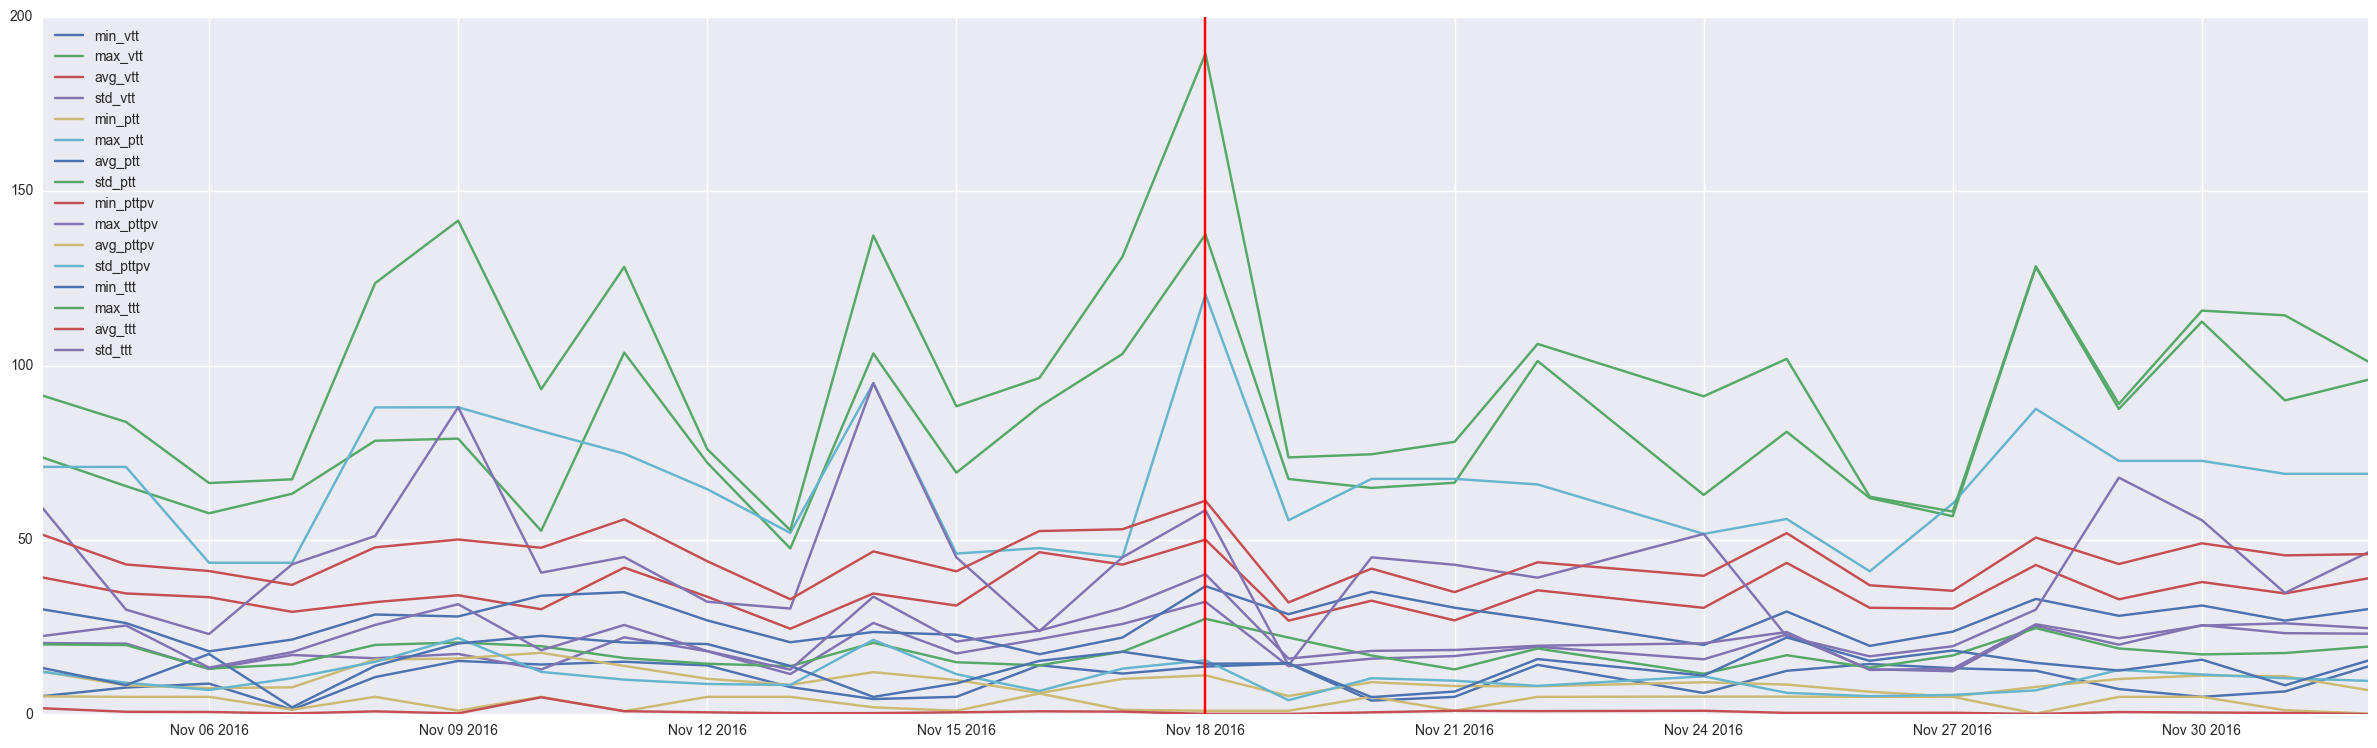

In [19]:
location_dfs['1-BAY']['data'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r');

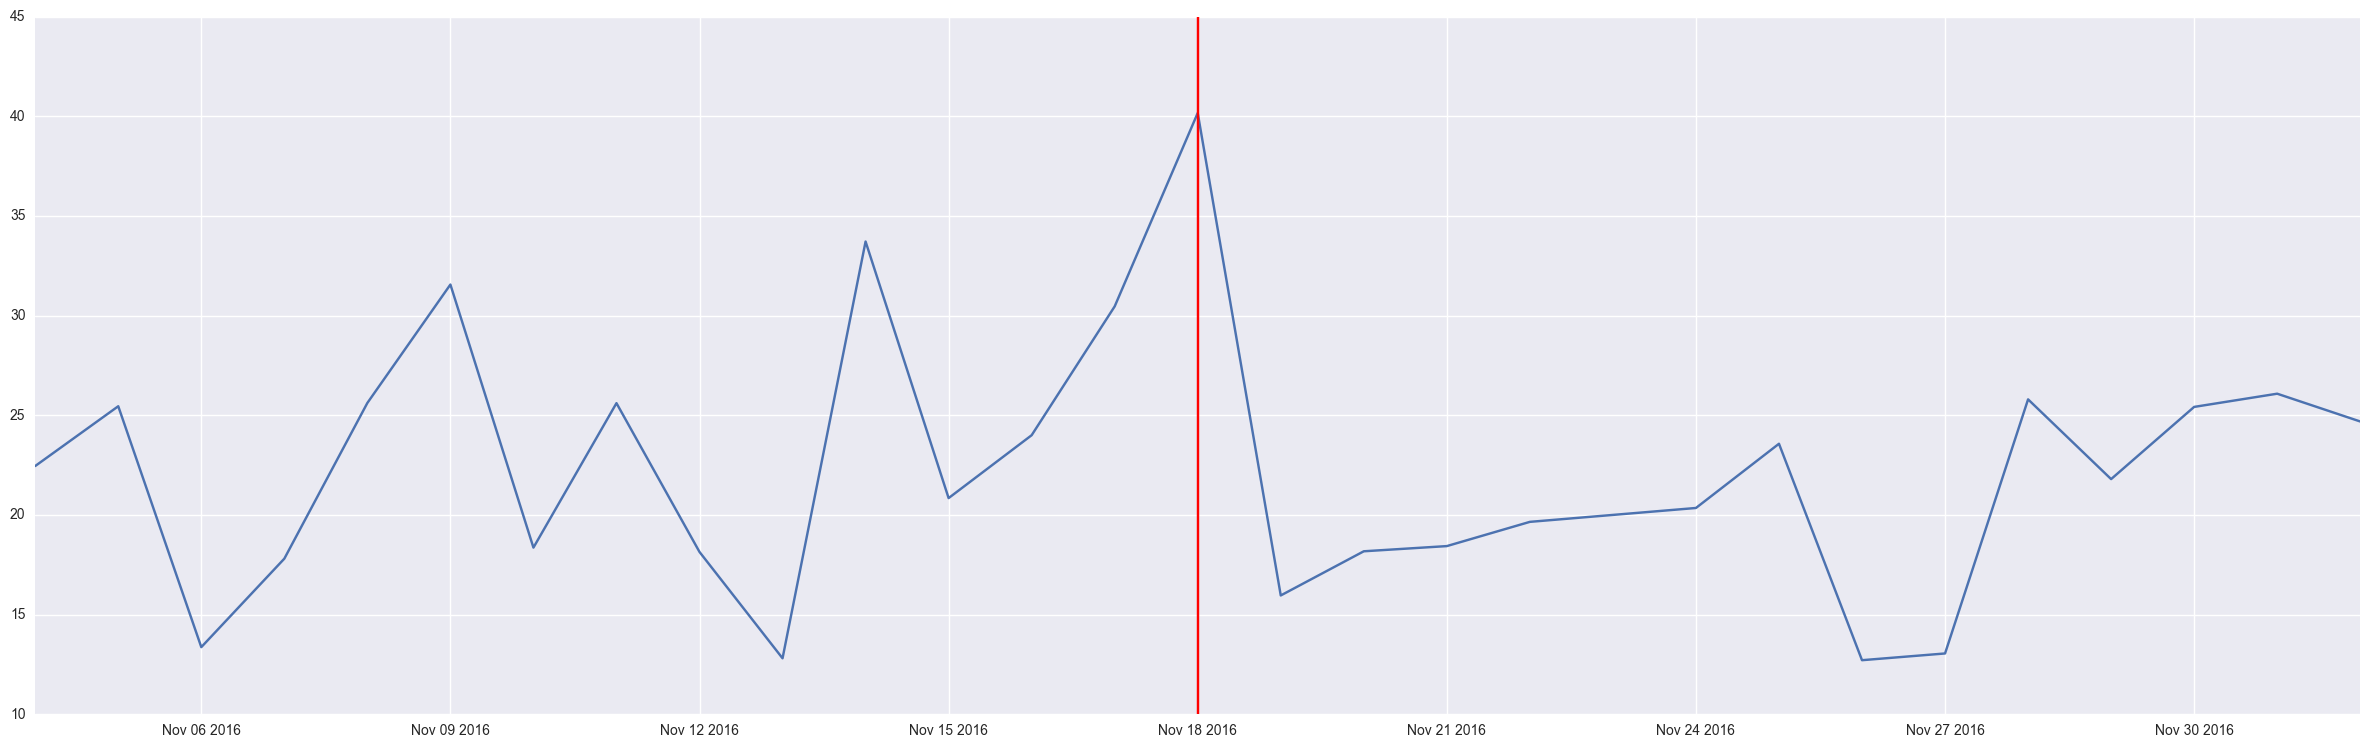

In [20]:
location_dfs['1-BAY']['data']['std_ttt'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r');

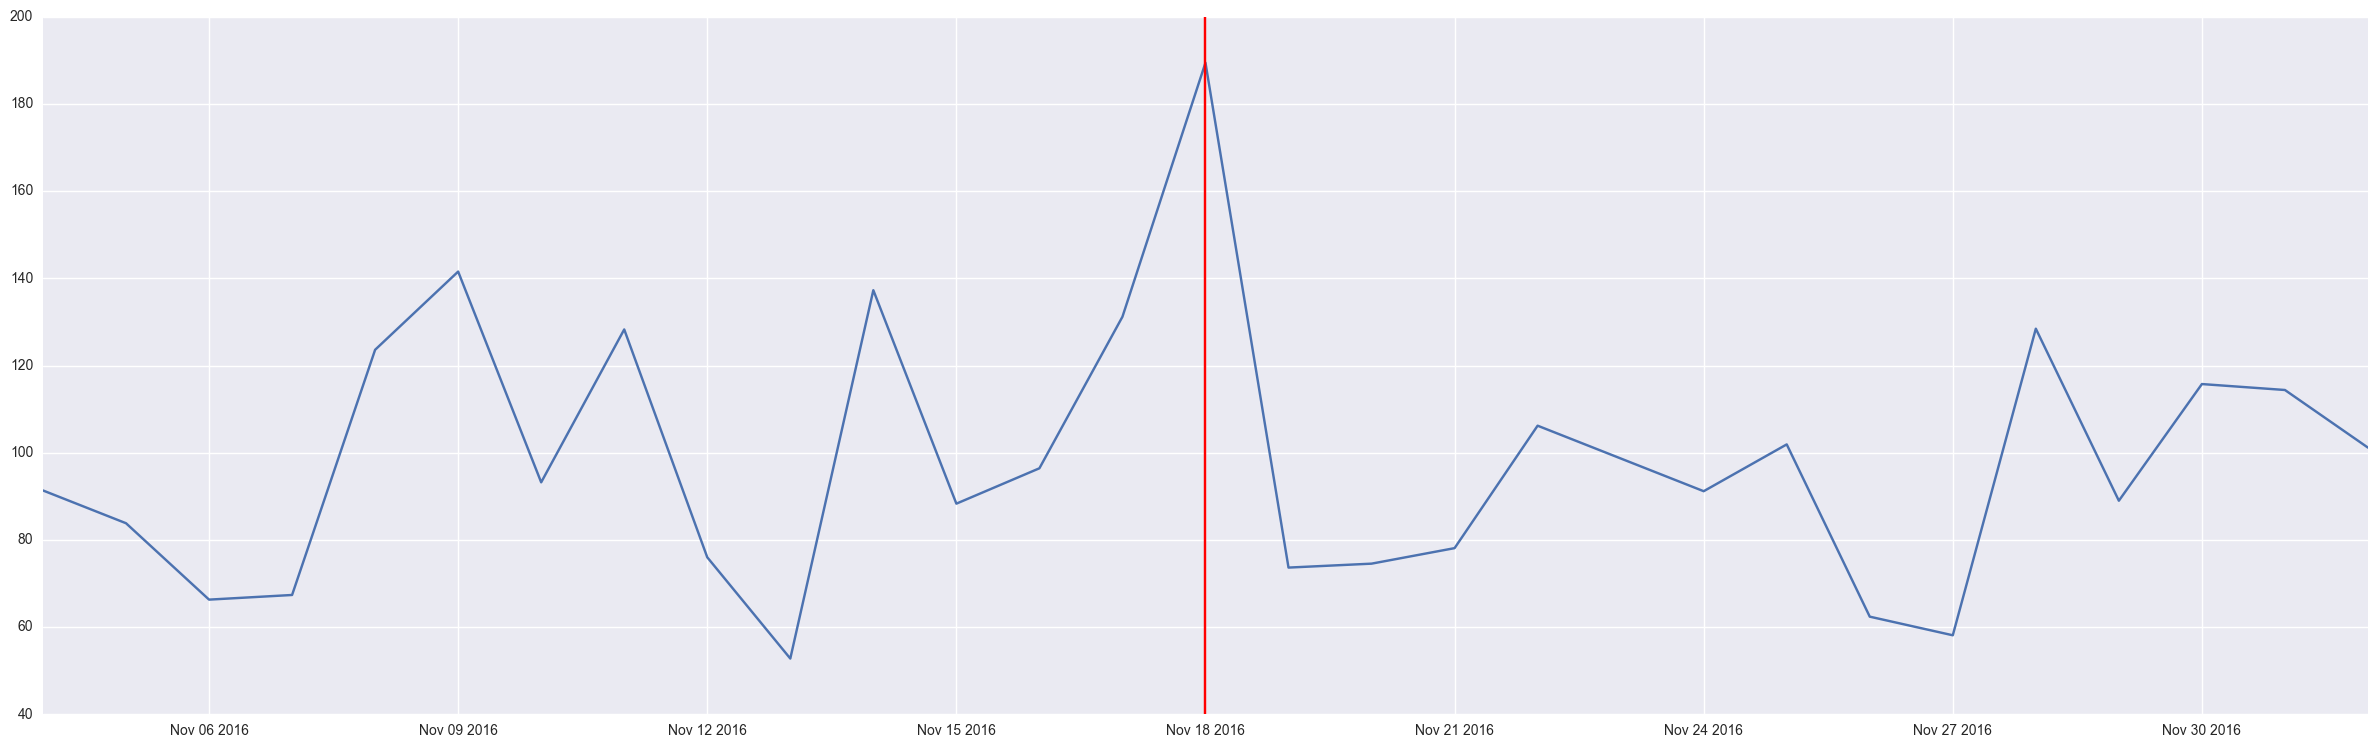

In [21]:
location_dfs['1-BAY']['data']['max_ttt'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r');

### Statistical Analysis

In [22]:
logic_change_date

datetime.date(2016, 11, 18)

In [23]:
# calculate before/after data split

for market in location_dfs:
    # before
    before_data = location_dfs[market]['data'][location_dfs[market]['data'].index < logic_change_date]
    location_dfs[market]['before'] = before_data
    
    # after
    after_data = location_dfs[market]['data'][location_dfs[market]['data'].index > logic_change_date]
    location_dfs[market]['after'] = after_data

In [24]:
location_dfs['1-BAY'].keys()

['after', 'data', 'before']

In [25]:
all(['market' in location_dfs[market][t].columns for t in ['before', 'after'] for market in location_dfs])

True

In [26]:
for market in location_dfs:
    
    print market
    
    # alias -- remember to drop market column for calculations below
    before = location_dfs.copy()[market]['before']
    before.drop('market', axis=1, inplace=True)
    after = location_dfs.copy()[market]['after']
    after.drop('market', axis=1, inplace=True)
    
    # calculate summary stats
    
    before_summary = [np.mean(before[metric].values) for metric in before.columns] 
    after_summary = [np.mean(after[metric].values) for metric in after.columns]

    stats = [ttest_ind(before[metric].values, after[metric].values, usevar='unequal') for metric in before.columns]

    stats = np.asarray(stats).T

    all_values = [before_summary, after_summary] + list(list(s) for s in stats)

    summary = pd.DataFrame(all_values, 
                             columns=before.columns, 
                             index=['before', 'after', 't_score', 'p_value', 'df'])
    
    # finally, save to each market in our lookup
    location_dfs[market]['summary'] = summary

2-NY
6-DAL
5-CHI
1-BAY


/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7-HOU
9-MIA
8-ATL
4-LA


In [27]:
location_dfs['7-HOU']['before'].head()

,min_vtt,max_vtt,avg_vtt,std_vtt,min_ptt,max_ptt,avg_ptt,std_ptt,min_pttpv,max_pttpv,avg_pttpv,std_pttpv,min_ttt,max_ttt,avg_ttt,std_ttt
2016-11-04,30.598333,53.888333,38.721167,7.217751,10.000000,55.687500,40.312667,10.947955,4.302917,55.687500,21.040492,14.621106,35.598333,92.306667,59.761658,16.735569
2016-11-05,10.000000,28.657500,14.731500,8.080329,29.932500,68.324167,43.130167,14.859019,11.738889,68.324167,30.216861,22.257689,29.903333,78.324167,44.948361,19.124368
2016-11-06,10.056667,51.111667,29.419417,14.640000,5.000000,63.181667,29.687583,18.168562,2.500000,31.590833,16.244069,9.754187,21.795556,71.064583,45.663486,14.611837
2016-11-07,10.000000,53.151667,31.987197,14.693442,5.000000,63.550000,27.691591,22.760034,1.666667,63.550000,23.676465,20.792074,30.763333,92.983333,55.663662,19.208955
2016-11-08,20.683333,39.833333,30.538125,9.498271,10.113333,45.303333,29.202917,14.755677,3.371111,45.303333,22.991389,20.029967,24.054444,82.715833,53.529514,29.171158


### Finally, view the statistical summaries by Market

In [28]:
# simple viewing
for market in markets:
    print market
    print
    print '-'*60
    print location_dfs[market]['summary'].head()
    print '-'*60
    print

1-BAY

------------------------------------------------------------
           min_vtt    max_vtt    avg_vtt    std_vtt    min_ptt    max_ptt  \
before    9.657917  75.540476  34.904904  18.543302   3.470774  65.071488   
after     9.909615  82.850705  34.153569  18.993854   3.361090  64.346667   
t_score  -0.148288  -0.927032   0.344871  -0.253053   0.134589   0.122054   
p_value   0.883305   0.363329   0.733076   0.802328   0.894041   0.903969   
df       24.999992  23.513433  24.996659  24.624853  24.397767  21.906833   

           avg_ptt    std_ptt  min_pttpv  max_pttpv  avg_pttpv  std_pttpv  \
before   25.324385  17.077218   0.966303  46.515298  11.121360  11.944694   
after    27.976601  17.468884   0.498720  37.380833   8.210567   8.526200   
t_score  -1.362557  -0.310382   1.420728   1.240409   2.661507   2.326902   
p_value   0.185268   0.759039   0.175731   0.226786   0.014861   0.030010   
df       24.802216  23.227931  15.088671  24.058069  20.312760  21.091189   

      

In [29]:
# pick out where we had a positive impact

metrics = cols[1:]

for market in markets:
    print market
    print 
    
    t_scores = location_dfs[market]['summary'].ix['t_score']
    p_values = location_dfs[market]['summary'].ix['p_value']
    
    for i, (t_score, p_value) in enumerate(zip(t_scores, p_values)):
        if t_score > 0:
            print '\t', metrics[i]
            print '\t\tt_score:', t_score, 
            print '\t\tp_value:', p_value
    
    print
    print '-'*80

1-BAY

	avg_vtt
		t_score: 0.344871481233 		p_value: 0.73307597362
	min_ptt
		t_score: 0.134588875034 		p_value: 0.894041097229
	max_ptt
		t_score: 0.122053661307 		p_value: 0.903969248585
	min_pttpv
		t_score: 1.42072789584 		p_value: 0.175731227199
	max_pttpv
		t_score: 1.24040934888 		p_value: 0.226785505612
	avg_pttpv
		t_score: 2.66150739485 		p_value: 0.0148614209969
	std_pttpv
		t_score: 2.32690222205 		p_value: 0.0300102412332
	min_ttt
		t_score: 0.349928719548 		p_value: 0.729426959184
	max_ttt
		t_score: 0.660225852082 		p_value: 0.515407698538
	avg_ttt
		t_score: 1.48322003222 		p_value: 0.150531616512
	std_ttt
		t_score: 1.13251706081 		p_value: 0.268776844071

--------------------------------------------------------------------------------
2-NY

	min_vtt
		t_score: 1.5256804346 		p_value: 0.139691583907
	max_vtt
		t_score: 0.0968259058083 		p_value: 0.923637341073
	avg_vtt
		t_score: 1.34363048863 		p_value: 0.194838731241
	max_ptt
		t_score: 2.01458096901 		p_value: 0.054

In [30]:
# build out the entire table

pre_pivot = []
pivot_cols = ['market', 'metric', 'before', 'after', 't-score', 'p-value', 'df']

for market in location_dfs:
    for metric in location_dfs[market]['summary']:
        v = location_dfs[market]['summary'][metric]
        pre_pivot.append([market, metric]+list(v.values))
        

pivot = pd.DataFrame(pre_pivot, columns=pivot_cols)
pivot.head()


,market,metric,before,after,t-score,p-value,df
0,2-NY,min_vtt,14.198869,10.898269,1.525680,0.139692,24.901287
1,2-NY,max_vtt,55.789940,55.400385,0.096826,0.923637,24.979468
2,2-NY,avg_vtt,32.491943,29.962833,1.343630,0.194839,19.069720
3,2-NY,std_vtt,13.803293,14.173938,-0.257565,0.799077,22.561153
4,2-NY,min_ptt,4.719286,5.222372,-1.229630,0.231675,22.260318


In [31]:
! pwd

/Users/lucasramadan/SCL-Work


In [32]:
pivot.to_csv('/Users/lucasramadan/SCL-Work/pickup_logic_change_analysis.csv', index=False)

In [33]:
# finally close the connection
conn.close()